In [1]:
import cloudpickle as pickle
from PIL import Image
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import imgaug.augmenters as iaa
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import torch.optim as optim

In [57]:
# d1['data'].shape
# d1['labels'].shape

(5000, 196608)

# Data Loading & Augmentation

In [2]:
def unpickle(filename):
    with open (filename,'rb') as fp:
        d1 = pickle.load(fp)
    return d1

def load_batch(batch):
    # dummy function, implement this
    # Return a numpy array of shape (N, height, width, #channels)
    # or a list of (height, width, #channels) arrays (may have different image sizes).
    # Images should be in RGB for colorspace augmentations.
    # (cv2.imread() returns BGR!)
    # Images should usually be in uint8 with values from 0-255.
    
    return batch.astype(np.uint8).reshape(-1,256,256,3) % 255

# Pipeline:
# (1) Horizontally flip 50% of the images.
# (2) Blur images using a gaussian kernel with sigma between 0.0 and 3.0.
seq1 = iaa.Sequential([
    iaa.Fliplr(0.8),
    iaa.GaussianBlur(sigma=(0, 1.5)),
    iaa.AddToHueAndSaturation((-5, 5)),
    iaa.BlendAlpha(0.5, iaa.Grayscale(1.0))
])

seq2 = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.GaussianBlur(sigma=(0, 2.0)),
    iaa.Flipud(0.2),
    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),
    iaa.WithBrightnessChannels(iaa.Add((-20, 20)))
])

seq3 = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.GaussianBlur(sigma=(0, 1.0)),
    iaa.LinearContrast((0.5, 1.5), per_channel=0.5), # improve or worsen the contrast
    iaa.Grayscale(alpha=(0.0, 0.3)),
    iaa.Emboss(alpha=(0.0, 1.0), strength=(0.5, 1.5))
#     iaa.Sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
#     iaa.Sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
#     iaa.Sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
])


###  Augmentation begins here
output_data = []
output_label = []

count_0 = 0
count_2 = 0


for i in range(1,6):
    d1 = unpickle('batch_'+str(i)+'.pickle')
    data = d1['data']
    labels = d1['labels'].astype(int).reshape(5000)
    # for the 5 batches, upload 2000 0s, all 1s, and 2000 2s. Augment label 3 and label 4 by 2 times.
    for k in range(labels.shape[0]):
        if labels[k] == 0 and count_0 < 2000:
            output_data.append(data[k])
            output_label.append(labels[k])
            count_0 += 1
        if labels[k] == 2 and count_2 < 2000:
            output_data.append(data[k])
            output_label.append(labels[k])
            count_2 += 1
        if labels[k] == 1:
            output_data.append(data[k])
            output_label.append(labels[k])
        if labels[k] == 3:
            output_data.append(data[k])
            output_label.append(labels[k])

            images = load_batch(data[k])
            images_aug = seq1(images = images).reshape(196608)
            output_data.append(images_aug)
            output_label.append(labels[k])

#             images_aug = seq2(images = images).reshape(196608)
#             output_data.append(images_aug)
#             output_label.append(labels[k])

            images_aug = seq3(images = images).reshape(196608)
            output_data.append(images_aug)
            output_label.append(labels[k])
        if labels[k] == 4:
            output_data.append(data[k])
            output_label.append(labels[k])

            images = load_batch(data[k])
            images_aug = seq1(images = images).reshape(196608)
            output_data.append(images_aug)
            output_label.append(labels[k])

            images_aug = seq2(images = images).reshape(196608)
            output_data.append(images_aug)
            output_label.append(labels[k])

#                 images_aug = seq3(images = images).reshape(196608)
#                 output_data.append(images_aug)
#                 output_label.append(labels[k])

output_data = np.array(output_data)
output_label = np.array(output_label)
print(output_label)
# the below operation is way too costly
# print('0:', np.count_nonzero(output_label == 0),'1:', np.count_nonzero(output_label == 1),\
#      '2:', np.count_nonzero(output_label == 2), '3: ',np.count_nonzero(output_label == 3),\
#      '4:', np.count_nonzero(output_label == 4))

[0 0 0 ... 4 4 4]


In [3]:
output_data.shape, output_label.shape

((9074, 196608), (9074,))

In [4]:
def count_label(output_label_array):
    total_0 = 0
    total_1 = 0
    total_2 = 0
    total_3 = 0
    total_4 = 0
    for i in output_label:
        if i == 0:
            total_0 += 1
        if i == 1:
            total_1 += 1
        if i == 2:
            total_2 += 1
        if i == 3:
            total_3 += 1
        if i == 4:
            total_4 += 1
    return (total_0,total_1,total_2,total_3,total_4)
count_label(output_label)

(2000, 1753, 2000, 1680, 1641)

In [ ]:
# dic = {}
# dic['data'] = output_data
# dic['labels'] = output_label
# with open('batch_after_augmentation.pickle', 'wb') as f:
#     pickle.dump(dic, f)
# with open('batch_after_augmentation.pickle','rb') as fp:
#     d8=pickle.load(fp)

In [2]:
np.save('data.npy', output_data) # save
np.save('label.npy', output_label) # save

NameError: name 'output_data' is not defined

In [44]:
SCALE = 1
dpi = 80
IMG_SIZE = 256
height, width = IMG_SIZE, IMG_SIZE
figsize = (width/float(dpi))/SCALE, (height/float(dpi))/SCALE

CLASSES = ['No DR', 'Mild','Moderate','Severe','Proliferative DR']

def index_to_class_name(y):
    return CLASSES[int(y)]
def class_name_to_index(class_name):
    return CLASSES.index(class_name)

def show_multiple_images(data, data_y, n_show=6, columns=3):
    ## given an array of data, show all of them as images
    fig=plt.figure(figsize=(10, 10))
    n = min(data.shape[0], n_show)
    rows = math.ceil(n/columns)
    for i in range(n):
        img = data[i].reshape(256,256,3)
        ax = fig.add_subplot(rows, columns, i+1) ## subplot index starts from 1 not 0
        class_name = index_to_class_name(data_y[i])
        ax.set_title(str(data_y[i])+": "+class_name)
        plt.imshow(img, cmap = 'gray')
    plt.show()

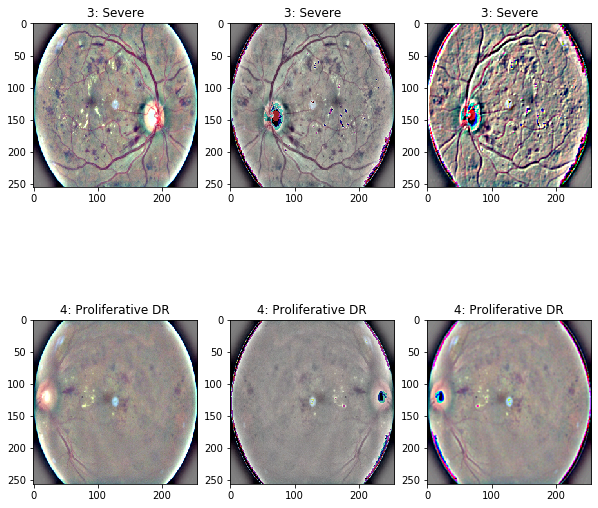

In [50]:
show_multiple_images(output_data[128:136], output_label[128:136])

In [ ]:
data = np.load('data.npy') # load
label = np.load('label.npy') # load

In [4]:
# split training, val, test set
total_count = data.shape[0]
train_count = math.ceil(total_count * 0.7)
val_count = math.ceil((total_count - train_count) * 0.5)
test_count = total_count - train_count - val_count
print(total_count, train_count, val_count, test_count)
X_all = np.array(data).reshape(total_count,3,256,256)
y_all = np.array(label).astype(int).reshape(total_count) # each label is a np int64 obj
X_train = X_all[:train_count]
y_train = y_all[:train_count]
X_val = X_all[train_count:(train_count+val_count)]
y_val = y_all[train_count:(train_count+val_count)]
X_test = X_all[(train_count+val_count):(train_count+val_count+test_count)]
y_test = y_all[(train_count+val_count):(train_count+val_count+test_count)]

9074 6352 1361 1361


In [5]:
X_all.shape, y_all.shape, X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape, type(y_test[1])

((9074, 3, 256, 256),
 (9074,),
 (6352, 3, 256, 256),
 (6352,),
 (1361, 3, 256, 256),
 (1361,),
 (1361, 3, 256, 256),
 (1361,),
 numpy.int64)

In [6]:
# normalize RGB data
X_train_normalized = X_train/255.0
X_val_normalized =  X_val/255.0
X_test_normalized = X_test/255.0
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((6352, 3, 256, 256),
 (6352,),
 (1361, 3, 256, 256),
 (1361,),
 (1361, 3, 256, 256),
 (1361,))

In [7]:
# torch.nn.Cov2d(input image channel, output channel, x: x*x square convolution kernel(filter)，stride =1, padding = 1)
# default padding is 0
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3,6,3,2,1)
        self.conv2 = nn.Conv2d(6,16,3,1,1)
        
        self.fc1 = nn.Linear(16*32*32, 512)
        self.fc2 = nn.Linear(512,128)
        self.fc3 = nn.Linear(128,5)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        x = x.reshape(x.shape[0], -1)
#         softmax = nn.Softmax(dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
batch_size = 128

# prepare for mini-batch stochastic gradient descent
n_data = X_train_normalized.shape[0]
n_batch = int(np.ceil(n_data/batch_size))

# convert X_train and X_val to tensor and flatten them
X_train_tensor = Tensor(X_train_normalized).reshape(train_count, -1)
X_val_tensor = Tensor(X_val_normalized).reshape(val_count,-1)

# convert training label to tensor and to type long
y_train_tensor = Tensor(y_train).long()
y_val_tensor = Tensor(y_val).long()

print('X train tensor shape:', X_train_tensor.shape)

X train tensor shape: torch.Size([6352, 196608])


In [9]:
# init network
conv_net = ConvNet()
print('model structure: ', conv_net)
# init optimizer
optimizer = optim.Adam(conv_net.parameters(), lr=1e-3)
# set loss function
# weight = torch.FloatTensor([0.5, 2, 2, 2, 2])
criterion = nn.CrossEntropyLoss()

model structure:  ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=5, bias=True)
)


In [10]:
## start 
def get_number_correct(pred, label):
    # find the largest number and return the index of that num
    pred_number = torch.argmax(pred,dim=1)
    res = (pred_number == label).long().sum()
#     print(pred_number, label)
    return res
n_iteration = 100
train_loss_list = np.zeros(n_iteration)
train_accu_list = np.zeros(n_iteration)
val_loss_list = np.zeros(n_iteration)
val_accu_list = np.zeros(n_iteration)

for i in range(n_iteration):
    running_loss = 0
    correct_train = 0
    # first get a minibatch of data
    for j in range(n_batch):
        batch_start_index = j*batch_size
        # get data batch from the normalized data
        X_batch = X_train_tensor[batch_start_index:(batch_start_index+batch_size)]
        # get ground truth label y
        y_batch = y_train_tensor[batch_start_index:(batch_start_index+batch_size)]
        
        pred = conv_net(X_batch.reshape(-1, 3, 256, 256))
        loss = criterion(pred, y_batch)
        running_loss += loss.item()
        correct_train += get_number_correct(pred, y_batch)
        # update 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    running_loss /= n_batch
    pred_val = conv_net(X_val_tensor.reshape(-1, 3, 256, 256))
    loss_val = criterion(pred_val, y_val_tensor).item()
    train_acc = correct_train/float(train_count)
    val_acc =  get_number_correct(pred_val, y_val_tensor)/float(val_count)
    print("Iter %d ,Train loss: %.3f, Train acc: %.3f, Val loss: %.3f, Val acc: %.3f" 
          %( i,running_loss, train_acc, loss_val, val_acc)) 
#     i ,ave_train_loss, train_accu, val_loss, val_accu
    ## add to the logs so that we can use them later for plotting
    train_loss_list[i] = running_loss
    train_accu_list[i] = train_acc
    val_loss_list[i] = loss_val
    val_accu_list[i] = val_acc  

Iter 0 ,Train loss: 1.377, Train acc: 0.495, Val loss: 1.522, Val acc: 0.139
Iter 1 ,Train loss: 1.493, Train acc: 0.419, Val loss: 1.760, Val acc: 0.139
Iter 2 ,Train loss: 1.650, Train acc: 0.186, Val loss: 1.484, Val acc: 0.139
Iter 3 ,Train loss: 1.587, Train acc: 0.280, Val loss: 1.488, Val acc: 0.139
Iter 4 ,Train loss: 1.655, Train acc: 0.383, Val loss: 1.510, Val acc: 0.139
Iter 5 ,Train loss: 1.734, Train acc: 0.327, Val loss: 1.717, Val acc: 0.139
Iter 6 ,Train loss: 1.592, Train acc: 0.265, Val loss: 1.719, Val acc: 0.139
Iter 7 ,Train loss: 1.578, Train acc: 0.168, Val loss: 1.711, Val acc: 0.139
Iter 8 ,Train loss: 1.525, Train acc: 0.250, Val loss: 1.573, Val acc: 0.139
Iter 9 ,Train loss: 1.626, Train acc: 0.151, Val loss: 1.710, Val acc: 0.139
Iter 10 ,Train loss: 1.560, Train acc: 0.237, Val loss: 1.749, Val acc: 0.139
Iter 11 ,Train loss: 1.552, Train acc: 0.285, Val loss: 1.787, Val acc: 0.139
Iter 12 ,Train loss: 1.503, Train acc: 0.263, Val loss: 1.553, Val acc: 0.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/estheryao/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-d62f459c68e1>", line 34, in <module>
    pred_val = conv_net(X_val_tensor.reshape(-1, 3, 256, 256))
  File "/Users/estheryao/anaconda/lib/python3.6/site-packages/torch/nn/modules/module.py", line 532, in __call__
    result = self.forward(*input, **kwargs)
  File "<ipython-input-7-795b0558aaca>", line 15, in forward
    x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
  File "/Users/estheryao/anaconda/lib/python3.6/site-packages/torch/_jit_internal.py", line 181, in fn
    return if_false(*args, **kwargs)
  File "/Users/estheryao/anaconda/lib/python3.6/site-packages/torch/nn/functional.py", line 488, in _max_pool2d
    input, kernel_size, stride, padding, dilation, ceil_mode)
KeyboardInterrupt

During handling of the above exception, another exception occurr

KeyboardInterrupt: 

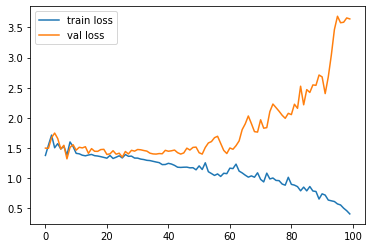

In [19]:
## plot training loss versus validation loss
x_axis = np.arange(n_iteration)
plt.plot(x_axis, train_loss_list, label='train loss')
plt.plot(x_axis, val_loss_list, label='val loss')
plt.legend()
plt.show()

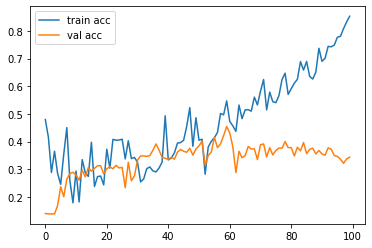

In [20]:
## plot training accuracy versus validation accuracy
plt.plot(x_axis, train_accu_list, label='train acc')
plt.plot(x_axis, val_accu_list, label='val acc')
plt.legend()
plt.show()

In [ ]:
## test performance on the test set and report final performance

X_test_tensor = torch.from_numpy(X_test_normalized).float().reshape(X_test_normalized.shape[0],-1)
y_test_tensor = torch.from_numpy(y_test).long()
pred_test = mlp(X_test_tensor)
test_correct,test_acc = get_correct_and_accuracy(pred_test, y_test_tensor)

print("Test accuracy: ",test_acc )

# Two other augmentation methods

In [ ]:
import torchvision
from torch.utils import data

class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
            iaa.Scale((224, 224)),
            iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0))),
            iaa.Fliplr(0.5),
            iaa.Affine(rotate=(-20, 20), mode='symmetric'),
            iaa.Sometimes(0.25,
                          iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
                                     iaa.CoarseDropout(0.1, size_percent=0.5)])),
            iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)
        ])
      
    def __call__(self, img):
        return self.aug.augment_image(img)

transforms = ImgAugTransform()

dataset = torchvision.datasets.ImageFolder('pytorch-examples/data/', transform=transforms)
dataloader = data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=4)
for idx, batch in enumerate(dataloader):
    # 128 * 256 * 256 * 3
    train(batch)

In [ ]:
import json
from PIL import Image
import torch
from torchvision import transforms

from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0')

# Preprocess image
tfms = transforms.Compose([transforms.Resize(224), transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])
img = tfms(Image.open('img.jpg')).unsqueeze(0)
print(img.shape) # torch.Size([1, 3, 224, 224])

# Load ImageNet class names
labels_map = json.load(open('labels_map.txt'))
labels_map = [labels_map[str(i)] for i in range(1000)]

# Classify
model.eval()
with torch.no_grad():
    outputs = model(img)

# Print predictions
print('-----')
for idx in torch.topk(outputs, k=5).indices.squeeze(0).tolist():
    prob = torch.softmax(outputs, dim=1)[0, idx].item()
    print('{label:<75} ({p:.2f}%)'.format(label=labels_map[idx], p=prob*100))